In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import sys
sys.path.append('..')
import TFUtil
%load_ext autoreload
%autoreload 2

In [31]:
NEG_INF = -float("inf")

def logsumexp(*args):  # summation in linear space -> LSE in log-space
    """
    Stable log sum exp.
    """
    if all(a == NEG_INF for a in args):
        return NEG_INF
    a_max = max(args)
    lsp = np.log(sum(np.exp(a - a_max)
                   for a in args))
    return a_max + lsp


def log_softmax(acts, axis=None):
    """computes log(softmax(x, axis)) in a numerical stable way."""
    assert axis is not None
    a = acts - np.max(acts, axis=axis, keepdims=True)  # normalize for stability
    probs = np.sum(np.exp(a), axis=axis, keepdims=True)
    log_probs = a - np.log(probs)
    return log_probs

def print_diagonals(mat, axis1=0, axis2=1):
    flip_lp = np.flip(mat, axis=axis1)
    max_time = mat.shape[axis1]
    max_target = mat.shape[axis2]
    for n in range(1, max_time+max_target):
        # offset = 0 means main diagonal
        offset = max_target - n if max_time > max_target else n - max_time
        p = flip_lp.diagonal(axis1=axis1, axis2=axis2, offset=offset)
        #p = np.flip(flip_lp.diagonal(axis1=axis1, axis2=axis2, offset=offset), axis=0)
        print("n=%2d" % n, p)

In [3]:
def draw_dot_grid(max_time, max_target, t, u):
    plt.rcParams["figure.figsize"] = (20,10)
    plt.rcParams["axes.labelsize"] = 20
    plt.rcParams["xtick.labelsize"] = 20
    plt.rcParams["ytick.labelsize"] = 20
    
    fig, ax = plt.subplots()
    plt.gca().invert_yaxis()
    ax.xaxis.set_label_position('top')
    
    marker_style = dict(color='tab:blue',linestyle='', marker='o',
                        markersize=15, markerfacecoloralt='tab:red')
    for y in range(max_time):
        ax.plot(y*np.ones(max_target), **marker_style)
    for n in range(1, max_time+max_target-3):
        ax.plot([n, 0],[0, n], color='tab:green', linestyle=':')
        ax.text(n-0.5, 0.5, 'n=%d' % (n-1), color='tab:green', fontsize=20)
    ax.plot(u, t, marker='o', color='tab:red')
    ax.xaxis.set_label_position('top')
    ax.yaxis.set_label_position('left')
    ax.tick_params(axis='x', top=True, labeltop=True)
    ax.tick_params(axis='y', left=True, labelright=True)
    
    ax.set(xlabel='label (U)', ylabel='time (T)')

In [33]:
blank_index = 0
#n_time = 8
#n_target = 3
#n_vocab = 5
acts = np.array([[[0.1, 0.6, 0.1, 0.1, 0.1],
                      [0.1, 0.1, 0.6, 0.1, 0.1],
                      [0.1, 0.1, 0.2, 0.8, 0.1]],
                     [[0.1, 0.6, 0.1, 0.1, 0.1],
                      [0.1, 0.1, 0.2, 0.1, 0.1],
                      [0.7, 0.1, 0.2, 0.1, 0.1]]])
labels = [1, 2]
blank_index = 0
log_probs = log_softmax(acts, axis=2)

In [36]:
from ref_transduce import forward_pass
from rnnt_tf_impl import numpy_forward as forward_pass_debug
#i = 0
#alphas, ll_forward = forward_pass_debug(log_probs[i][:input_lengths[i], :label_lengths[i]+1], labels[i], blank_index=0, debug=True)
alphas, ll_forward = forward_pass_debug(log_probs, labels, blank_index=blank_index, debug=True)
print("\nlog probs:")
print_diagonals(log_probs[..., 0])
print("\nalphas:")
print_diagonals(alphas)

a = alpha[t-1, u] + log_probs[t - 1, u, blank_index]
b = alpha[t, u - 1] + log_probs[t, u - 1, labels[u - 1]]
alpha[t,u] = LSE(a,b)
U=3, T=2, V=5
t= 1 u= 0: alpha[0, 0] + log_probs[0, 0, 0] = 0.000 + -1.731 = -1.731
t= 0 u= 1: alpha[0, 0] + log_probs[0, 0, labels[0]=1] = 0.000 + -1.231 = -1.231
t= 0 u= 2: alpha[0, 1] + log_probs[0, 1, labels[1]=2] = -1.231 + -1.231 = -2.463
t= 1 u= 1: LSE(-1.231 + -1.731, -1.731 +  -1.231) = LSE(-2.963, -2.963) = -2.270
t= 1 u= 2: LSE(-2.463 + -1.811, -2.270 +  -1.530) = LSE(-4.274, -3.800) = -3.316
Alpha matrix: (2, 3)
[[ 0.         -1.2314292  -2.46285839]
 [-1.7314292  -2.26971121 -3.31609971]]
log-posterior = alpha[1, 2] + log_probs[1, 2, 0] = -3.316 + -1.180 = -4.4957

log probs:
n= 1 [-1.7314292]
n= 2 [-1.7314292 -1.7314292]
n= 3 [-1.63025393 -1.8113862 ]
n= 4 [-1.17956706]

alphas:
n= 1 [0.]
n= 2 [-1.7314292 -1.2314292]
n= 3 [-2.26971121 -2.46285839]
n= 4 [-3.31609971]


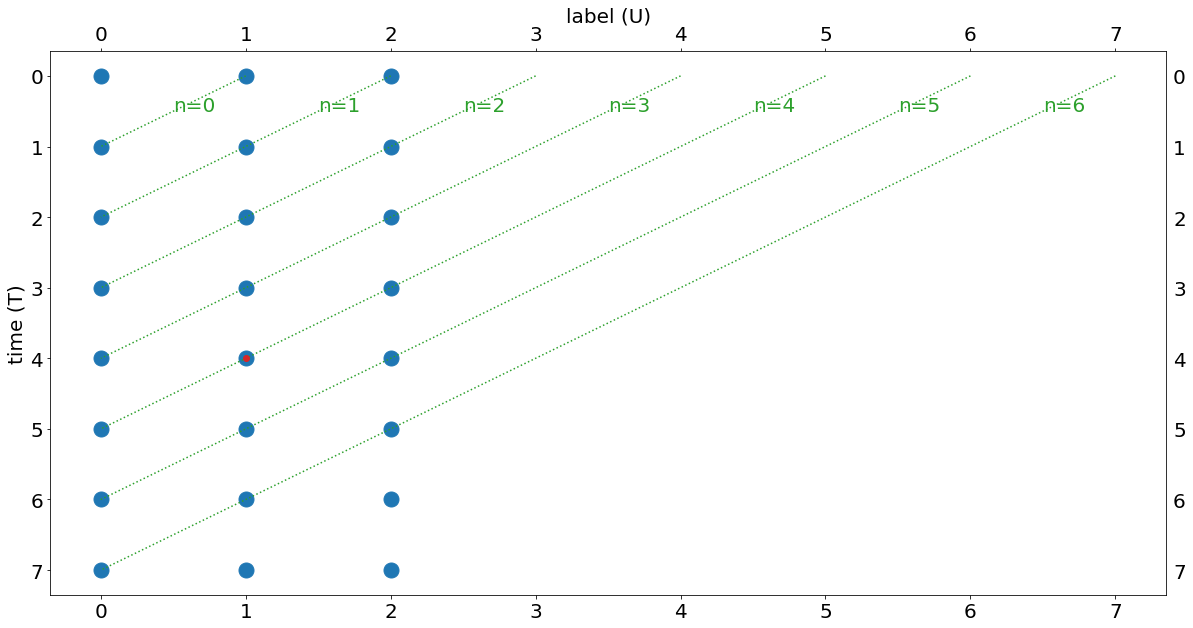

In [30]:
draw_dot_grid(max_time=max_input, max_target=max_target, t=input_lengths[i]-1, u=label_lengths[i])

In [34]:
log_probs[0,:,:,1]

array([[-3.09933334, -2.06861521, -2.31997681],
       [-2.34382583, -1.58533536, -1.67144196],
       [-2.98288632, -3.22848124, -2.58226684],
       [-1.11587209, -2.22822103, -1.93324247],
       [-3.08390324, -2.9489838 , -0.70355141],
       [-1.23603511, -3.81157125, -3.46205278],
       [-1.63430656, -3.1274054 , -2.20596296],
       [-3.8929666 , -0.751728  , -1.57108779]])

In [ ]:
n_batch = 4
max_input = 80
max_target = 20
n_vocab = 50
np.random.seed(42)
labels = np.random.randint(1, n_vocab, (n_batch, max_target-1))
input_lengths = np.random.randint(1, max_input, (n_batch,), dtype=np.int32)
label_lengths = np.random.randint(1, max_target - 1, (n_batch,), dtype=np.int32)
acts = np.random.normal(0, 1, (n_batch, max_input, max_target, n_vocab))


Warp Reference implementation: log-posterior=array([198.90388, 110.21467, 310.00992, 349.1648 ], dtype=float32), |alpha|=......, |grads|=11.2789
FINAL 	 i= 0 T= 80 U= 20 T'= 48 U'= 8 diag_idx= 56 within_diag_idx= 8 size(alpha) [20] [-246.583191 -220.922287 -221.330719 -216.849686 -213.135529 -208.563507 -206.527222 -195.425018 -194.100555 -190.424744 -190.542587 -191.381454 -189.420425 -187.629715 -187.322556 -186.30011 -187.353027 -183.384262 -181.601944 -179.754776]
FINAL 	 i= 1 T= 80 U= 20 T'= 15 U'= 16 diag_idx= 31 within_diag_idx= 16 size(alpha) [20] [-135.83548 -123.67569 -120.779274 -117.911011 -114.950989 -112.273544 -111.316963 -110.715248 -108.475639 -108.481285 -108.042702 -105.327019 -104.140495 -106.189674 -106.631004 -105.46907 -106.529922 -107.431656 -108.526024 -110.676376]
FINAL 	 i= 2 T= 80 U= 20 T'= 72 U'= 13 diag_idx= 85 within_diag_idx= 13 size(alpha) [20] [-356.168213 -352.577393 -351.455292 -340.644 -340.509186 -337.387085 -330.526581 -331.386932 -317.786713 -317.835419 -308.209412 -307.54248 -307.458191 -304.81427 -301.226196 -300.023224 -300.061798 -297.944916 -297.830963 -297.369812]
FINAL 	 i= 3 T= 80 U= 20 T'= 78 U'= 18 diag_idx= 96 within_diag_idx= 18 size(alpha) [20] [-344.777954 -337.358734 -334.723267 -332.850494 -331.392395 -330.195312 -329.212189 -328.45697 -327.956818 -327.732208 -327.799042 -328.176178 -328.89389 -330.0065 -331.622498 -334.021393 -349.257202 -349.009827 -345.771332 -347.446289]
TensorFlow implementation: log-posterior=array([-198.90388, -110.21467, -310.00992, -349.1648 ], dtype=float32), |alpha|=0.0000
TF vs Warp RNN-T: log posterior MATCH
TF vs Warp RNN-T: gradients MATCH
